### 도시가스 고객센터 상담이력정보 분석 - 01. EDA 
- Source Data : 이지원 상담이력정보 테이별(APDB_CL_CS_COUNSEL_CALL_HISTORY_TM) 
- DB info. : DataPlatform RDS(MSSQL)
- Data size : 13,558,241건 (2019.12.02~2023.07.21, 약 8.3GB) 
- columns 정보 : http://localhost:8888/doc/tree/work_2023/07.%EA%B5%90%EC%9C%A1_%EC%9D%B8%EC%9E%85%EC%BD%9C%ED%9A%A8%EC%9C%A8%ED%99%94/columns_detail.png
---

In [1]:
## 필수 pkg's 및 한글폰트 사용 설정 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

---
#### 1. Data loading 
- pymssql을 사용하여 데이터 플랫폼에 구성된 MSSQL DB에 접속 
  - cmd 환경에서 pymssql 사전 설치 필요 : python -m pip install pymssql==2.2.0 
- SQL query에 조건설정하여, '22년 데이터를 3개월 단위로 로딩 (full data loading시 메모리 부족) 
---

In [2]:
import pymssql 
import time 

## MSSQL 접속 & Connection 으로부터 Cursor 생성
conn = pymssql.connect(host="prd-samchully-dataplatform.cypt1acw82rx.ap-northeast-2.rds.amazonaws.com", user='bi_analy1', password='analy123!@#', database='scl_dataplatform', charset='utf8')
cursor = conn.cursor()

## query 
sql_statement_1 = '''
SELECT * from APDB_CL_CS_COUNSEL_CALL_HISTORY_TM
where START_TIME between '2022-01-01 00:00:00' and '2022-04-01 00:00:00'
;
'''

sql_statement_2 = '''
SELECT * from APDB_CL_CS_COUNSEL_CALL_HISTORY_TM
where START_TIME between '2022-04-01 00:00:00' and '2022-07-01 00:00:00'
;
'''

sql_statement_3 = '''
SELECT * from APDB_CL_CS_COUNSEL_CALL_HISTORY_TM
where START_TIME between '2022-07-01 00:00:00' and '2022-10-01 00:00:00'
;
'''

sql_statement_4 = '''
SELECT * from APDB_CL_CS_COUNSEL_CALL_HISTORY_TM
where START_TIME between '2022-10-01 00:00:00' and '2023-01-01 00:00:00'
;
'''

In [3]:
## 2022. 1Q data 
start = time.time()  # 시작 시간 저장
df_2022_1q = pd.read_sql(sql=sql_statement_1, con=conn)
print(df_2022_1q.shape)  
print("time :", time.time() - start)  ## 현재시각 - 시작시간 = 실행 시간

(932060, 58)
time : 160.26406741142273


In [4]:
## 2022. 2Q data 
start = time.time()  
df_2022_2q = pd.read_sql(sql=sql_statement_2, con=conn)
print(df_2022_2q.shape)
print("time :", time.time() - start) 

(814245, 58)
time : 135.76449751853943


In [5]:
## 2022. 3Q data 
start = time.time()  
df_2022_3q = pd.read_sql(sql=sql_statement_3, con=conn)
print(df_2022_3q.shape) 
print("time :", time.time() - start) 

(747475, 58)
time : 63.55937910079956


In [6]:
## 2022. 4Q data 
start = time.time()  
df_2022_4q = pd.read_sql(sql=sql_statement_4, con=conn)
print(df_2022_4q.shape)  
print("time :", time.time() - start)
conn.close() ## SQL DB 접속 종료 

(851842, 58)
time : 72.19032263755798


In [7]:
## 1Q~4Q 데이터 병합 -> 2022년 데이터셋 
df_2022_a = df_2022_1q.append(df_2022_2q, ignore_index=True)
df_2022_b = df_2022_a.append(df_2022_3q, ignore_index=True)
df_2022 = df_2022_b.append(df_2022_4q, ignore_index=True)

print(df_2022.shape)
df_2022.head(1)

(3345622, 58)


,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,...,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,...,None,여성,F,600315.0,None,None,None,None,96953091,700737322


---
#### 2. 데이터 개략 리뷰 및 전처리 
- 2022년 상담이력 데이터 총량 3,345,622건 (컬럼수 58개) 
- call_id, 납부자번호, 이름 등 식별성 정보는 분석대상에서 제외 
- 1차 데이터 전처리 내역 
  - 1) 상담 시작&끝 시간으로부터, 해당 월/일/시간 추출하여 신규컬럼 생성 
  - 2) 상담 소요시간(call_time)은 1000분의 1초 단위임 -> 분석편의를 위해 초단위로 변환 
  - 3) 생년월일(BIRTH_DATE) 컬럼으로 부터, '22년 기준 연령 계산 -> 계산로직 구상 중(미완료)
---

In [8]:
pd.set_option('display.max_columns', None)
df_2022.head(2)

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,1,오정,16,None,SUCCESS,40,LOF1,548A5FA2-44DA-43C7-976B-F36D10B7CF8B,요금 내역서 발송,MODESTY,OWN,16,UPDATE,2022-01-06 10:18:11,2022-01-06 10:16:59,1721.0,1721.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,공동주택,업무용,겸손,요금문의,온화함,None,None,통화성공,6091,None,None,삼정동,None,여성,F,600315.0,None,None,None,None,96953091,700737322
1,182612760.0,03180199756,IB,0상담원연결,2022-01-06 10:17:29,2022-01-06 10:17:59,30000.0,304366212,김진영,GENERAL,1,동인천,11,None,SUCCESS,10,LRH1,9389BB5F-A391-4B53-9254-103F496A3B89,수납센터: 번호변경&요금문자요청,DOUCENESS,OWN,11,UPDATE,2022-01-06 10:18:41,2022-01-06 10:17:30,1677.0,1677.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,원룸,난방용,차분,요금문의,온화함,None,None,통화성공,6030,None,None,도화1동,None,남성,M,851024.0,None,None,None,None,96953118,707153261


In [9]:
## 전처리-1 : 상담 시작&끝 시간으로부터, 해당 월/일/시간/요일 추출 
df_2022['call_month'] = df_2022['START_TIME'].dt.month
df_2022['call_day'] = df_2022['START_TIME'].dt.day
df_2022['call_hour'] = df_2022['START_TIME'].dt.hour
df_2022['call_weekday'] = df_2022['START_TIME'].dt.day_name()

## 전처리-2 : 상담 소요시간(call_time)은 1000분의 1초 단위임 -> 초단위로 변환
df_2022['call_duration'] = df_2022['CALL_TIME'] / 1000 

df_2022.head(2)

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_month,call_day,call_hour,call_weekday,call_duration
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,1,오정,16,None,SUCCESS,40,LOF1,548A5FA2-44DA-43C7-976B-F36D10B7CF8B,요금 내역서 발송,MODESTY,OWN,16,UPDATE,2022-01-06 10:18:11,2022-01-06 10:16:59,1721.0,1721.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,공동주택,업무용,겸손,요금문의,온화함,None,None,통화성공,6091,None,None,삼정동,None,여성,F,600315.0,None,None,None,None,96953091,700737322,1,6,10,Thursday,56.0
1,182612760.0,03180199756,IB,0상담원연결,2022-01-06 10:17:29,2022-01-06 10:17:59,30000.0,304366212,김진영,GENERAL,1,동인천,11,None,SUCCESS,10,LRH1,9389BB5F-A391-4B53-9254-103F496A3B89,수납센터: 번호변경&요금문자요청,DOUCENESS,OWN,11,UPDATE,2022-01-06 10:18:41,2022-01-06 10:17:30,1677.0,1677.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,원룸,난방용,차분,요금문의,온화함,None,None,통화성공,6030,None,None,도화1동,None,남성,M,851024.0,None,None,None,None,96953118,707153261,1,6,10,Thursday,30.0


In [10]:
## 전처리-3 : 생년월일(BIRTH_DATE) 컬럼으로 부터, '22년 기준 연령 계산
## 기본형태가 6자리 숫자(예: 851024.0, type: float64)로 되어있고, 0, 1, 999999 등 부적합한 값이 많아 추출에 주의 필요 
## 연령 계산을 위한 로직 구상 중 ... (일단 보류) 
#sns.distplot(df_2022['BIRTH_DATE'])
#print('- min value =', np.min(df_2022['BIRTH_DATE']))
#print('- mean value =', np.mean(df_2022['BIRTH_DATE']))
#print('- max value =', np.max(df_2022['BIRTH_DATE']))

---
### 3. 주요 현황 리뷰 
---

1     299550
2     321445
3     311065
4     281094
5     281366
6     251785
7     251600
8     256192
9     239683
10    259055
11    287499
12    305288
Name: call_month, dtype: int64


<AxesSubplot:xlabel='call_month', ylabel='count'>

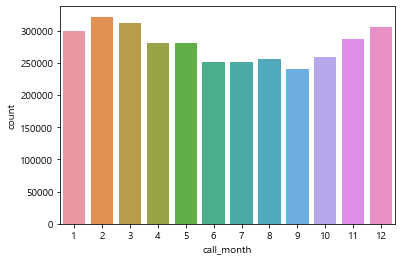

In [11]:
## 1-1) 월별 통화량 추이는? 
call_cnt = df_2022['call_month'].value_counts()
print(call_cnt.sort_index())

sns.countplot(data=df_2022, x='call_month')

1      80810
2     102559
3     100473
4     124619
5     102913
6      89020
7     140687
8     118782
9      81024
10     95670
11    125786
12     96993
13     98449
14    132074
15    102921
16    104708
17    109312
18    121433
19    110801
20    105477
21    133195
22    124753
23    109250
24    114927
25    125083
26    108108
27     98961
28    136177
29    100363
30     94675
31     55619
Name: call_day, dtype: int64


<AxesSubplot:xlabel='call_day', ylabel='count'>

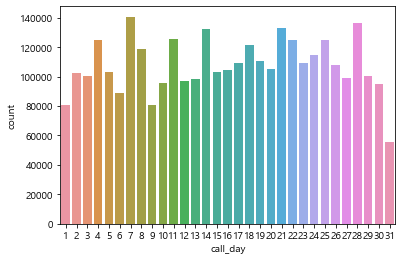

In [12]:
## 1-2) 월중 통화량이 많은 날짜는?
call_cnt2 = df_2022['call_day'].value_counts()
print(call_cnt2.sort_index())

sns.countplot(data=df_2022, x='call_day')

Friday       626811
Monday       712176
Saturday     150837
Sunday         1623
Thursday     601096
Tuesday      652340
Wednesday    600739
Name: call_weekday, dtype: int64


<AxesSubplot:xlabel='call_weekday', ylabel='count'>

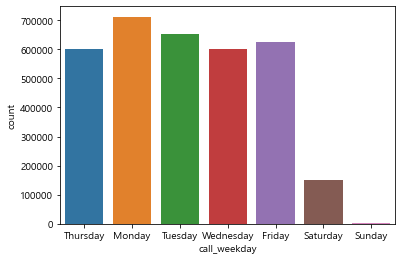

In [13]:
## 1-3) 통화량이 많은 요일은?
call_cnt3 = df_2022['call_weekday'].value_counts()
print(call_cnt3.sort_index())

sns.countplot(data=df_2022, x='call_weekday')

0          7
1          6
2          1
5          3
6         14
7        108
8      12527
9     435886
10    461675
11    426377
12     16516
13    485883
14    444608
15    408921
16    368950
17    274451
18      5698
19      1375
20       960
21      1606
22        39
23        11
Name: call_hour, dtype: int64


<AxesSubplot:xlabel='call_hour', ylabel='count'>

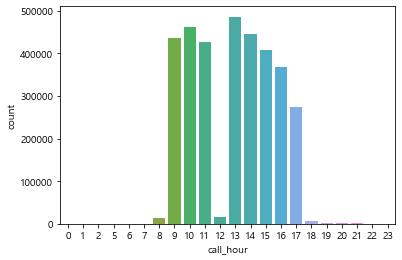

In [14]:
## 1-4) 통화량이 많은 시간대는?
call_cnt4 = df_2022['call_hour'].value_counts()
print(call_cnt4.sort_index())

sns.countplot(data=df_2022, x='call_hour')

##### summary 
- 매월 약 25 ~ 30만건의 통화 발생, 11~3월의 동절기 통화량이 하절기 대비 약 16%정도 많음 
- 월중 특정 날짜(월초, 월말 등)에 통화량이 집중되는 패턴은 보이지 않음 
- 요일별로는 월요일이 약 70만건으로 가장 많고, 화 ~ 금요일은 60~65만건 수준 (주말 통화량은 15만건 수준) 
- 하루중 시간대 별로는 오전 9시에서 오후 4시까지에 통화량 집중
---

In [15]:
## 2-1) 특정 고객이 빈번하게 통화하는가? 
x1 = 3345622   ## 전체 콜수 
x2 = df_2022['PAYER_NUMBER'].nunique()  ##납부자 번호가 동일한 경우 1콜로 가정 
y = (x1-x2)/x1
print('- 같은 고객이 2번이상 전화한 비중% =', round(y*100,2))

- 같은 고객이 2번이상 전화한 비중% = 54.65


In [16]:
## 2-2) 특정 고객이 계속 반복적으로 통화하는가? 그 정도는 어느수준인가? 
from collections import Counter
x3 = dict(Counter(df_2022['TEL']))  ## 전화번호별 중복횟수를 dict 형태로 저장 
x3_df = pd.DataFrame.from_dict(x3, orient='index')  ## 데이터프레임 형태로 변환 
x3_df.columns = ['call_cnt']
x3_df.head()

,call_cnt
0326796155,1
03180199756,2983
0215447000,8605
01065978698,2
01037678831,29


In [17]:
print('1인당 평균 통화횟수 = ', np.mean(x3_df['call_cnt']))
print('1인 최다 통화횟수 = ', np.max(x3_df['call_cnt']))
x3_df.sort_values('call_cnt', ascending = False)[:10]

1인당 평균 통화횟수 =  2.382302321689874
1인 최다 통화횟수 =  66690


,call_cnt
NaN,66690
15881688,10128
0215447000,8605
0313783910,5069
03180199756,2983
03180199705,2578
0263295322,2529
0328304690,2522
03180199739,2461
03180199755,2332


In [18]:
## 전화번호가 NaN인 것은 제외하고 다시 관찰 
x4_df = x3_df[x3_df['call_cnt'] != 66690 ]
print('1인당 평균 통화횟수 = ', np.mean(x4_df['call_cnt']))
print('1인 최다 통화횟수 = ', np.max(x4_df['call_cnt']))
x4_df.sort_values('call_cnt', ascending = False)[:10]

1인당 평균 통화횟수 =  2.3348163296695157
1인 최다 통화횟수 =  10128


,call_cnt
15881688,10128
0215447000,8605
0313783910,5069
03180199756,2983
03180199705,2578
0263295322,2529
0328304690,2522
03180199739,2461
03180199755,2332
03180199750,2154


<AxesSubplot:xlabel='call_cnt'>

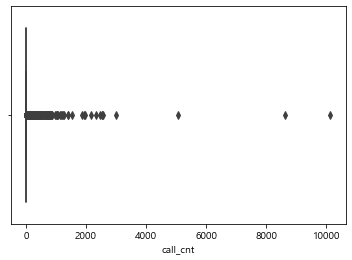

In [19]:
sns.boxplot(x4_df['call_cnt'])

- 전체 콜의 절반이상(55%)이 동일한 고객이 여러차례 통화하였음 
- '22년 고객 1인당 평균 통화횟수는 2.4회이나, 극소수 고객들의 경우 몇천건에서 최대 1만건까지 통화한 내역 존재 
- 연간 몇천건 이상 반복적으로 발생하는 콜들에 대한, 발생원인 및 대응방법 개선 모색이 필요 
  - 예. 15881688(국민카드), 0215447000(신한카드), 0313783910(부동산), 03180199756 ~ 03180199750(도시가스 미납 안내) 
--- 

In [20]:
## 참고. 1588-1688(국민카드)로 부터의 콜 내용은? 
df_temp = df_2022[df_2022['TEL'] == '15881688' ]
df_temp['COUNSEL_MEMO'][:20]

465                                              롯데카드해지
819                                            카드자동이체해지
909                                           자동이체해지만요청
1245                                   카드자동이체변경으로  해지요청
2005                                          자동이체 해지요청
2101                                             카드해지요청
2178                                    카드해지-카드사로 등록한다함
2185                                          세대무관 간단문의
2193             카드자동이체 해지및 LMS고지서요청  /3월요금 별도 납부하셔야함안내
2203                                               None
2232                                       카드 자동이체 해지만.
2441                                               자동해지
3192                                      카드해제만..문자발송안내
3489                               자이 해지 및 지로 고지서 변경 요청
4284    국민카드사 연락옴 >> 기존 카드해지 문의 >  본인 연락주셔서 해지요청만 가능안내.
4405                                             카드해지요청
4432                                             카드해지요청
4938                         카드사 고객번호 확인문의 -고객이 

In [21]:
## 참고. 03180199756(부동산)로 부터의 콜 내용은? 
df_temp = df_2022[df_2022['TEL'] == '0313783910' ]
df_temp['COUNSEL_MEMO'][:20]

1281                                     공급문의
2664                              렌지부근 누설점검요청
5461                        363 / 66,850원 집주인
5728                                     None
6241                                     None
6437                                     불꽃문의
6476             3/31계량기쪽 가스냄새/오후접수,원규리님배우자통화
6752                                   LPG세대임
6930                       가스누설 무조건 방문해주시라고하심
7564       11시반전/방문10분전 전화//타이머설치(95,000원 안내)
7593                       가스가 안나온다고 함..방문접수함
7677                밖에배관 가스 셈(점검원 확인해줌) /보민안내
9080                            경보기작동했다고 점검요청
9109                           가스 차단기 작동 점검요청
9734     가스 사용안되는 세대 (이노타워는 주거용으로 가스 공급 확인안됨)
11503                               요양보호사/ 렌교
12433                                     당직 
13177                   a/s접수확인_방문전 연락번호 변경요청
13178                                   가스 냄새
13391                                    None
Name: COUNSEL_MEMO, dtype: object

In [22]:
## 참고. 0313783910(도시가스 미납 안내)로 부터의 콜 내용은? 
df_temp = df_2022[df_2022['TEL'] == '03180199756' ]
df_temp['COUNSEL_MEMO'][:20]

1                                        수납센터: 번호변경&요금문자요청
755      수납센터  폰삭제   &  사무실번호 등록요청   2021.11~2022.2월내역 ...
1097                                     수납센터/ 번호변경 후 금액문자
1805                                             수납센터-요금문자
2600                                        수납센터/일회성 15만원만
3314                                      수납센터/알림톡고지 폰번호확인
5467                              수납센터 고객 10만원결재 금액과계좌문자전송
7334                           수납센터 전화줌  자동이체 신청으로 번호 문자요청
7965                                 수납센터) 번호 등록, 금액 계좌 문발
9703                                         수납센터/종이고지서로변경
12699                       수납센터)010-3604-9771로 미납요금 문발 요청
14323                                       수납센터 핸드폰 번호 변경
14951                                     수납센터요청 고지서 재발행요청
15856                                      전번변경요청함/수납센터요청함
16374                                                 None
19544                                                 None
20930             수납센터 전화주심 2개월분 206,010원 카드결재로 가상번호 발급 

---

1콜 평균 통화시간(분) =  2.15
1콜 최대 통화시간(분) =  339.5


<AxesSubplot:xlabel='call_duration'>

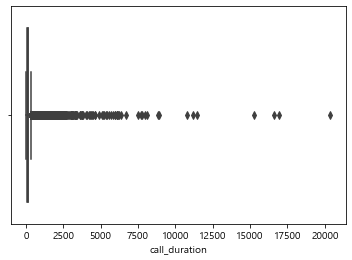

In [23]:
## 3-1) 콜당 통화시간은 어느정도인가? 
a = np.mean(df_2022['call_duration'])
b = np.max(df_2022['call_duration'])
print('1콜 평균 통화시간(분) = ', round(a/60, 2))
print('1콜 최대 통화시간(분) = ', round(b/60, 2))

sns.boxplot(df_2022['call_duration'])

In [24]:
## 3-2) 통화시간이 지나치게 긴 건들은 어떤 것들인가?
df_2022.sort_values('call_duration', ascending = False)[:10]

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_month,call_day,call_hour,call_weekday,call_duration
2282622,264541952.0,0328304520,OB,None,2022-08-25 09:35:45,2022-08-25 15:15:15,20370000.0,None,None,None,None,군포,36,None,None,None,None,2C002447-2990-41E9-997F-0D5D105E2F40,None,None,None,None,UPDATE,2022-08-25 15:15:15,2022-08-25 09:35:45,1815.0,1815.0,None,None,None,None,None,None,아웃바운드,None,None,None,None,None,None,None,None,None,None,6273,None,None,None,None,None,None,NaN,None,None,None,None,None,None,8,25,9,Thursday,20370.0
252606,205579812.0,15880075,OB,None,2022-03-04 11:31:40,2022-03-04 16:13:51,16931000.0,None,None,None,None,장안,39,None,None,None,None,ADDDA60B-759B-4560-B938-FCC585605970,None,None,None,None,UPDATE,2022-03-04 16:13:52,2022-03-04 11:31:41,1837.0,1837.0,None,None,None,None,None,None,아웃바운드,None,None,None,None,None,None,None,None,None,None,6318,None,None,None,None,None,None,NaN,None,None,None,None,None,None,3,4,11,Friday,16931.0
2629524,307095097.0,01080093169,OB,None,2022-12-23 11:51:02,2022-12-23 16:27:37,16595000.0,None,None,None,None,동인천,11,None,None,None,None,79F3E2CA-6519-424E-9247-B7EBE81372B3,None,None,None,None,UPDATE,2022-12-23 16:27:38,2022-12-23 11:51:03,1682.0,1682.0,None,None,None,None,None,None,아웃바운드,None,None,None,None,None,None,None,None,None,None,6035,None,None,None,None,None,None,NaN,None,None,None,None,None,None,12,23,11,Friday,16595.0
3242506,279002226.0,01076265023,OB,None,2022-10-11 11:03:48,2022-10-11 15:17:44,15236000.0,None,None,None,None,처인,45,None,None,None,None,D9ED9ECE-98E8-4357-A547-EBA6116A939A,None,None,None,None,UPDATE,2022-10-11 15:17:44,2022-10-11 11:03:48,1885.0,1885.0,None,None,None,None,None,None,아웃바운드,None,None,None,None,None,None,None,None,None,None,6395,None,None,None,None,None,None,NaN,None,None,None,None,None,None,10,11,11,Tuesday,15236.0
839959,204526812.0,0328304514,OB,None,2022-03-02 13:41:21,2022-03-02 16:51:50,11429000.0,None,None,None,None,주안,14,None,None,None,None,CAD03405-82A6-4E93-A548-132DD2A791E7,None,None,None,None,UPDATE,2022-03-02 16:51:51,2022-03-02 13:41:22,1702.0,1702.0,None,None,None,None,None,None,아웃바운드,None,None,None,None,None,None,None,None,None,None,6061,None,None,None,None,None,None,NaN,None,None,None,None,None,None,3,2,13,Wednesday,11429.0
3055572,305960915.0,01033214458,IB,9VARS가스누설 화재신고,2022-12-21 08:54:55,2022-12-21 12:00:49,11154000.0,306434652,None,None,None,None,None,None,None,None,None,5CC29CFF-85E3-4C13-8AFC-F1380AC554EB,None,None,None,None,UPDATE,2022-12-21 12:00:50,2022-12-21 08:54:55,1671.0,1671.0,None,None,None,None,None,None,인바운드,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,12,21,8,Wednesday,11154.0
3195112,276551844.0,01036806081,IB,9가스누설 화재신고,2022-10-02 18:21:56,2022-10-02 21:21:06,10750000.0,None,None,None,None,None,None,None,None,None,None,F69488F7-DC0F-475B-A04A-0A47BE385D11,None,None,None,None,UPDATE,2022-10-02 21:21:07,2022-10-02 18:21:56,1671.0,1671.0,None,None,None,None,None,None,인바운드,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,10,2,18,Sunday,10750.0
2745964,292350086.0,01037101454,IB,9가스누설 화재신고,2022

- 1콜당 평균 통화시간은 약 2분 정도이나, 일부 통화시간이 몇시간 이상인 건들도 존재함 
- 확인결과 Outbound call중 기계적 오류이거나, 사고신고 ... ????? 
   - -> 비정상적인 통화시간 건들을 제외해야 의미있는 분석이 가능할 듯 
--- 

IB      2895086
OB       450269
null         38
Name: BOUND_TYPE_CODE, dtype: int64


<AxesSubplot:xlabel='BOUND_TYPE_CODE', ylabel='count'>

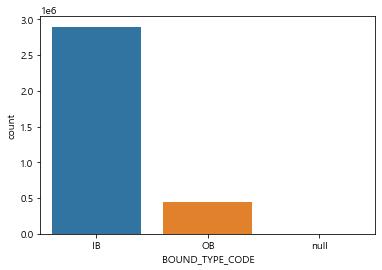

In [25]:
## 4-1) In / Out bound 비중 
print(df_2022['BOUND_TYPE_CODE'].value_counts())
sns.countplot(df_2022['BOUND_TYPE_CODE'])

0상담원연결                     2025791
8이사 방문접수                    335783
0VARS상담사 연결                 305143
0기타 문의사항                    120275
0VARS기타 문의사항                 13709
3VARS전자고지자동이체 신청해지            7309
종합상황실                         5829
9가스누설 화재신고                    4917
92기타 문의                       4760
2VARS요금조회및납부안내                4415
0도시가스재공급 접수                   4085
9VARS가스누설 화재신고                1218
1VARS방문예약 결과조회                 829
6VARS전출완료확인문자발송서비스             797
2요금조회및납부안내                     566
0VARS도시가스재공급 접수                361
5VARS신청서FAX및이메일발송              274
32VARS계좌신용카드 자동이체등록변경해지        194
8VARS이사 방문접수                   173
4VARS납부자번호조회                   121
Name: ARS_CHANNEL, dtype: int64


<AxesSubplot:xlabel='count', ylabel='ARS_CHANNEL'>

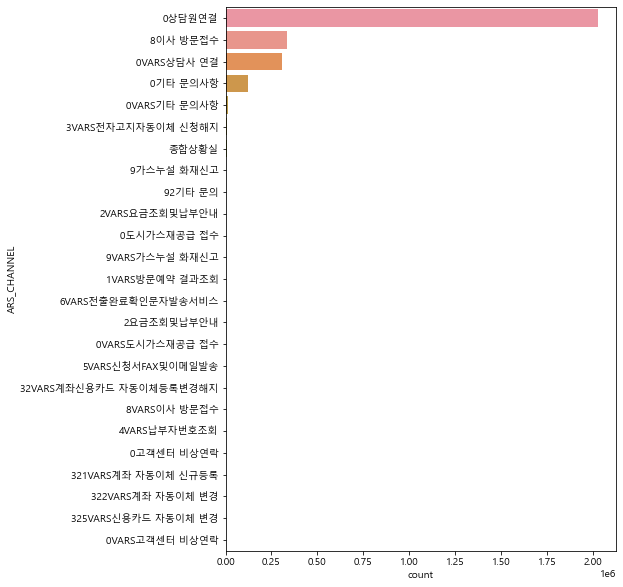

In [26]:
## 4-2) ARS 유형별 현황 
xx = df_2022['ARS_CHANNEL'].value_counts()
print(xx[:20])

plt.figure(figsize = (7,10))
sns.countplot(data=df_2022, y='ARS_CHANNEL', order=df_2022['ARS_CHANNEL'].value_counts().index)

- 인바운드 콜 비중이 대부분(86%)를 차지. 
- ARS 연결하여 상담원 연결을 요청하는 경우가 대다수(전체 ARS 2,836,678건 중 2,025,791건(약 71.4%))
  - -> 콜의 약 2/3가 상담원 연결 요청, ARS 메뉴설계 개편을 검토해 볼 필요가 있지 않을까? 
--- 

문의    3018426
불만      14005
긴급       6297
칭찬         22
Name: DUTY_TYPE_CLAS, dtype: int64


<AxesSubplot:xlabel='DUTY_TYPE_CLAS', ylabel='count'>

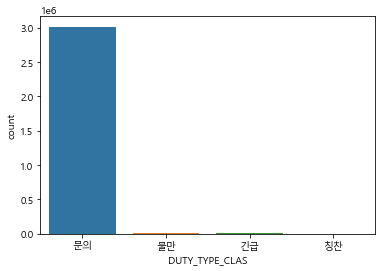

In [27]:
## 5-1) 업무유형(콜의 이유)는 어떤 것들인가? 
print(df_2022['DUTY_TYPE_CLAS'].value_counts())
sns.countplot(df_2022['DUTY_TYPE_CLAS'])

콜백건수 = 36881
###########################################################
콜백유형= 업무이관    34869
고객예약     2012
Name: CALLBACK_TYPE, dtype: int64


<AxesSubplot:xlabel='CALLBACK_TYPE', ylabel='count'>

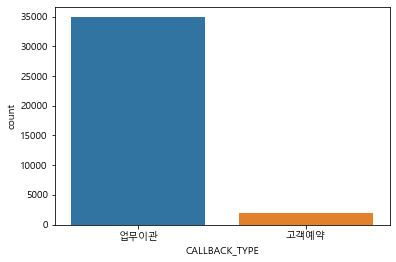

In [28]:
## 5-2) 한번 콜로 종료되지 않고, call back하는 케이스는 얼마나 되며 어떤 이유에서 콜백하는가? 
print('콜백건수 =', df_2022['CALLBACK_TYPE'].value_counts().sum())
print('###########################################################')
print('콜백유형=', df_2022['CALLBACK_TYPE'].value_counts())
sns.countplot(df_2022['CALLBACK_TYPE'])

온화함     2358999
정중함      408303
진지함       88131
산만함       56940
성급함       25172
까다로움      13837
민감함        5595
냉정함        5585
권위적        3759
열정적        3700
단호함        3663
Name: CUSTOMER_DIVISION, dtype: int64


<AxesSubplot:xlabel='CUSTOMER_DIVISION', ylabel='count'>

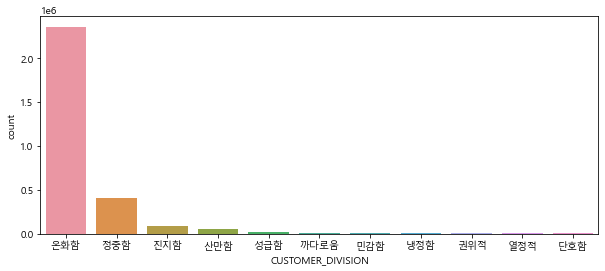

In [29]:
## 5-3) 고객의 attitude 
print(df_2022['CUSTOMER_DIVISION'].value_counts())
plt.figure(figsize = (10,4))
sns.countplot(data=df_2022, x='CUSTOMER_DIVISION', order=df_2022['CUSTOMER_DIVISION'].value_counts().index)

- 전체 콜의 절대다수(99.3%)가 문의건 (고객불만건은 약 0.5%) 
- 콜백하는 경우는 전체의 약 1%(약 368백건) 수준이며, 대부분 업무이관 케이스임 
- 고객의 attitude는 대부분 긍정적, 부정적으로 평가된 건은 약 3.7% 
   - *부정적 태도 : 산만한, 성급합, 까다로움, 민감함, 냉정함, 권위적

--- 

In [41]:
## 데이터프레임 내보내기 
#df_2022.to_csv('data/df_2022.csv', index=False, encoding="utf-8-sig")

## Parquet 압축하여 내보내기 
## 불러올때는 : df_2022 = pd.read_parquet('data/df_2022.parquet', engine = 'pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq
df_2022.to_parquet('data/df_2022.parquet', engine='pyarrow', index=False)